<a href="https://colab.research.google.com/github/Divyansh9125/Deep-Learning/blob/master/Disparity_Map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Topic:** Disparity map generation

**Author:** Divyansh Srivastava

In [0]:
#Importing necassry packages
from google.colab.patches import cv2_imshow
import cupy as cp
import math as m
import cv2

print("Packages are imported..")

Packages are imported..


In [0]:
#Now loading the images
L_path = "../content/pair2-L.png"
R_path = "../content/pair2-R.png"

In [0]:
print(cp.cuda.Device)

<class 'cupy.cuda.device.Device'>


Shape of left image: (200, 200)


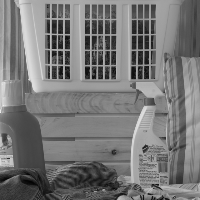


Shape of right image: (200, 200)


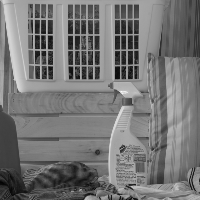

In [0]:
L_img = cv2.imread(L_path, cv2.IMREAD_GRAYSCALE)
R_img = cv2.imread(R_path, cv2.IMREAD_GRAYSCALE)
dim = (200, 200)
L_img = cv2.resize(L_img, dim)
R_img = cv2.resize(R_img, dim)
print("Shape of left image:", L_img.shape)
cv2_imshow(L_img)
print("\nShape of right image:", R_img.shape)
cv2_imshow(R_img)

In [0]:
#Convert the images to numpy array
with cp.cuda.Device(0):
  L_img = cp.array(L_img, dtype=cp.int64)
  R_img = cp.array(R_img, dtype=cp.int64)

print(type(L_img), type(R_img))

<class 'cupy.core.core.ndarray'> <class 'cupy.core.core.ndarray'>


In [0]:
#function to compute disparity
def computeDisparity(imgL, imgR, sz_win, step=1, numDisp=10):
  sz_imgL = imgL.shape
  sz_imgR = imgR.shape

  with cp.cuda.Device(0):
    disp_map = cp.zeros(sz_imgL, dtype=cp.int64)

    for i in range(sz_imgL[0]):
      for j in range(0, sz_imgL[1]-sz_win[1]):
        ssd = [m.inf, 0]
        sum1 = 0
        for l in range(max(0, j-numDisp),min(sz_imgL[1]-sz_win[1], j+numDisp), step):
        # for l in range(0, sz_imgL[1]-sz_win[1], step):
          winL = imgL[i:min(i+sz_win[0]+1, sz_imgL[0]), j:j+sz_win[1]+1]
          winR = imgR[i:min(i+sz_win[0]+1, sz_imgL[0]), l:l+sz_win[1]+1]
          sum1 = cp.sum(cp.absolute(winL-winR))
          if sum1<ssd[0]:
            ssd = [abs(sum1), abs(l-j)]

        disp_map[i][j] = ssd[1]

  return disp_map

In [0]:
#normalize disparity map
def normalizeDespMap(disp_map):
  with cp.cuda.Device(0):
    maximum = cp.amax(disp_map)
    disp_map = (disp_map*255)//maximum

  return disp_map

Enter space separated values for height and width of the window: 12 12
Enter disparity range: 25


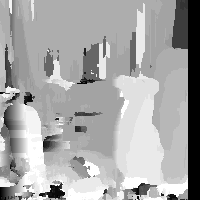

In [0]:
sz_win = tuple(map(int, input("Enter space separated values for height and width of the window: ").split()))
# step = int(input("Enter the pixel steps: "))
numDisp = int(input("Enter disparity range: "))
disp_map_LR = computeDisparity(L_img, R_img, sz_win, numDisp=numDisp)
cv2_imshow(cp.asnumpy(normalizeDespMap(disp_map_LR)))

Enter space separated values for height and width of the window: 12 12
Enter disparity range: 25


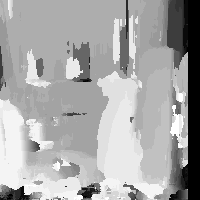

In [0]:
sz_win = tuple(map(int, input("Enter space separated values for height and width of the window: ").split()))
# step = int(input("Enter the pixel steps: "))
numDisp = int(input("Enter disparity range: "))
disp_map_RL = computeDisparity(R_img, L_img, sz_win, numDisp=numDisp)
cv2_imshow(cp.asnumpy(normalizeDespMap(disp_map_RL)))

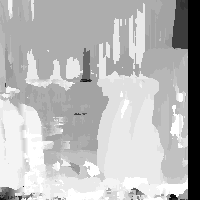

In [0]:
szx, szy = disp_map_LR.shape
disp_map = cp.zeros((szx, szy), dtype=cp.int64)
for i in range(szx):
  for j in range(szy):
    disp_map[i][j] = max(disp_map_LR[i][j], disp_map_RL[i][j])

cv2_imshow(cp.asnumpy(normalizeDespMap(disp_map)))

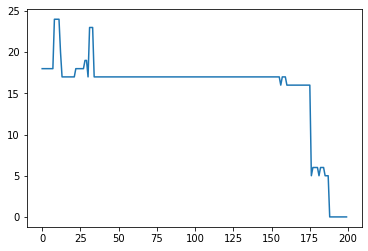

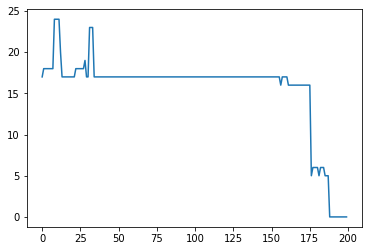

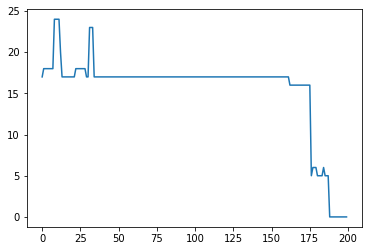

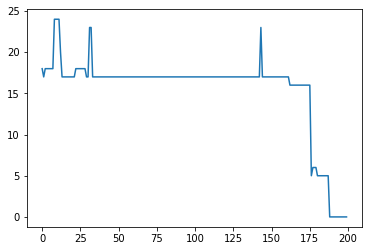

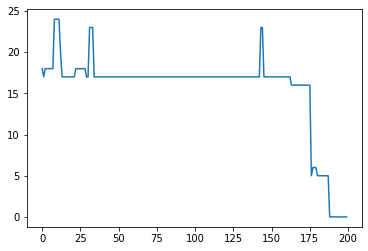

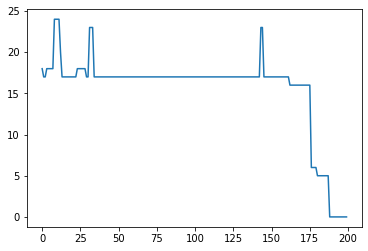

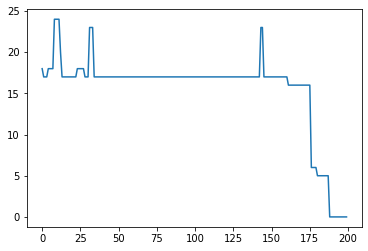

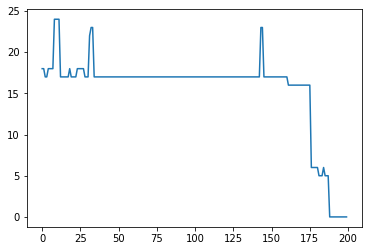

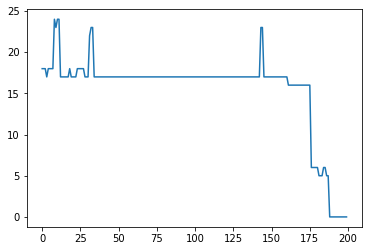

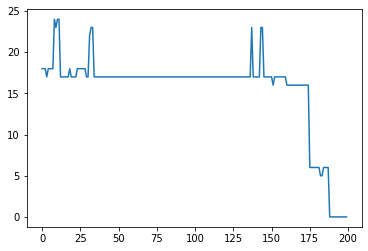

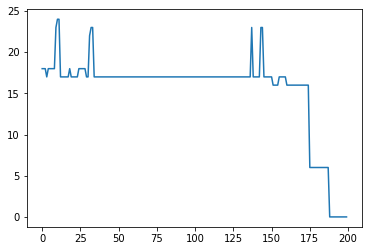

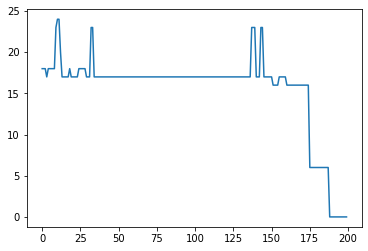

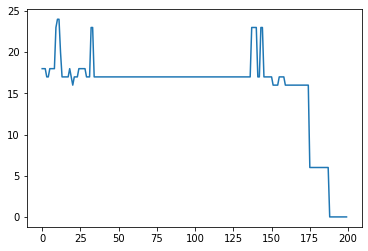

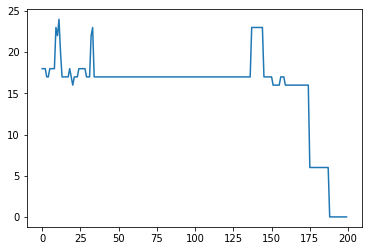

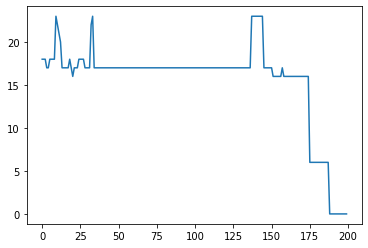

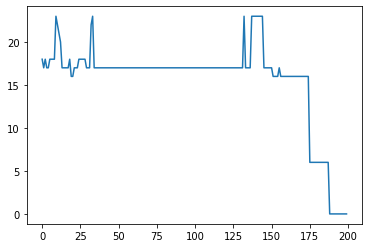

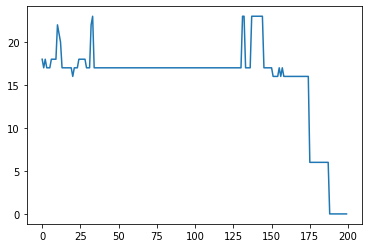

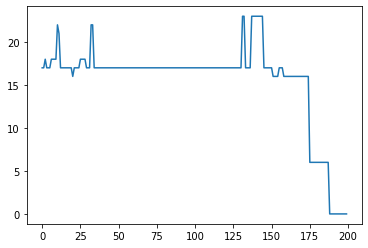

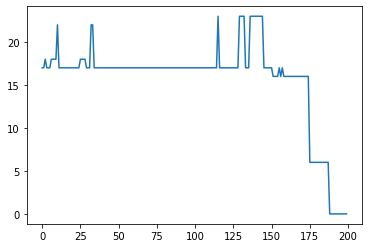

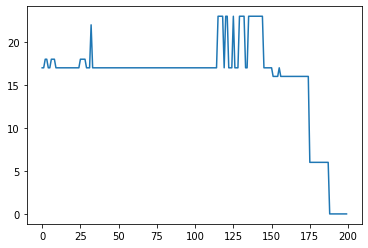

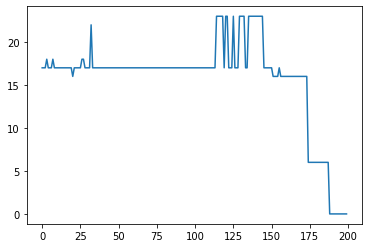

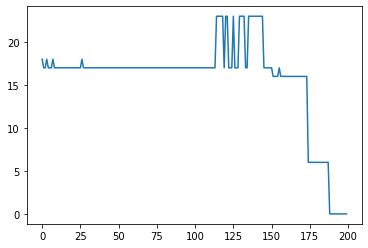

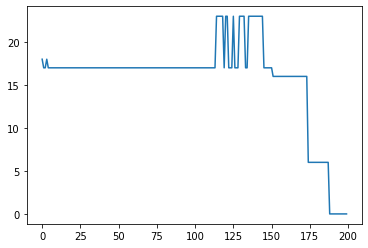

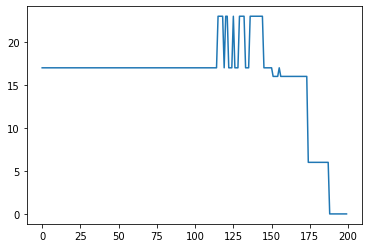

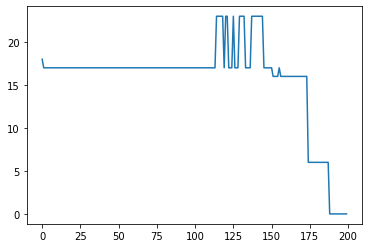

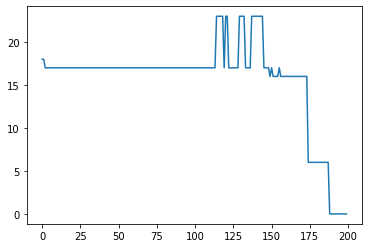

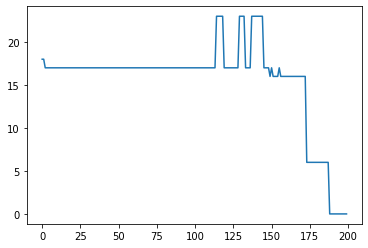

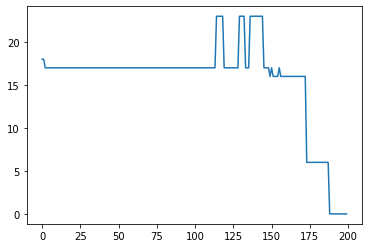

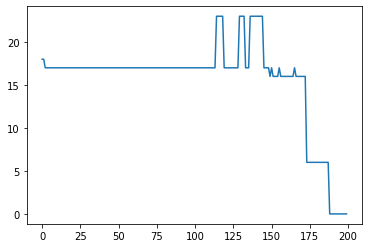

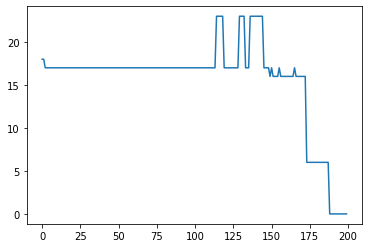

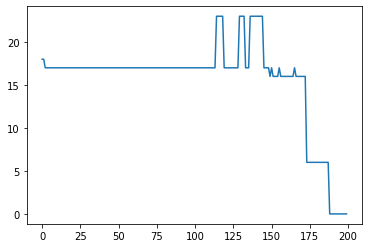

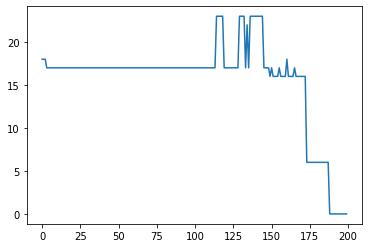

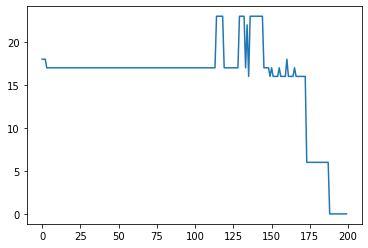

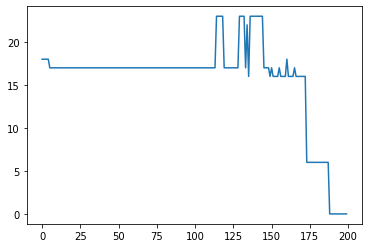

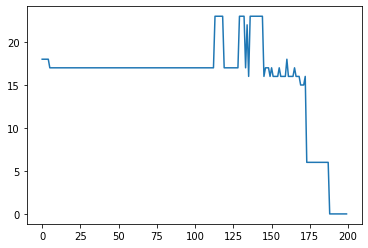

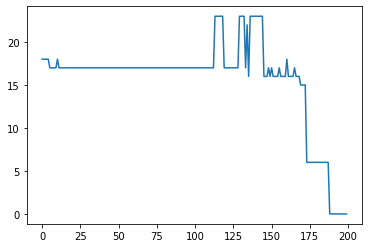

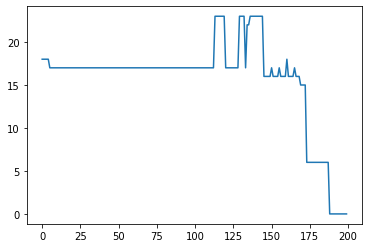

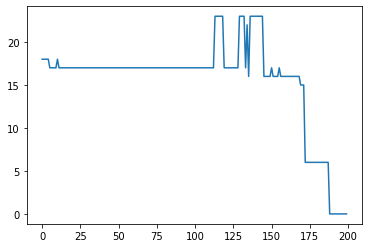

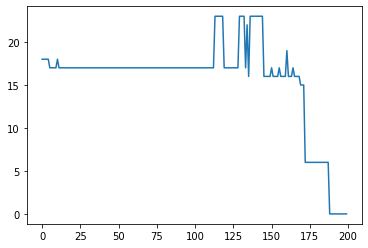

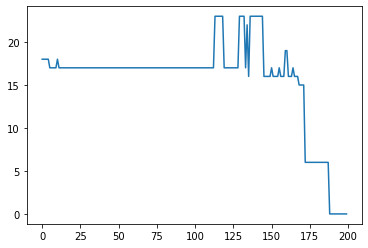

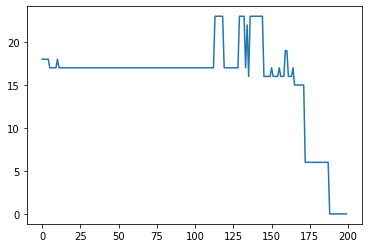

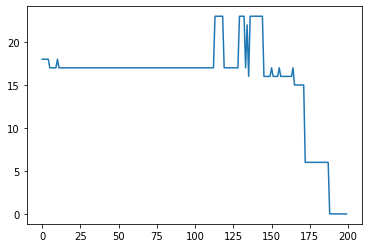

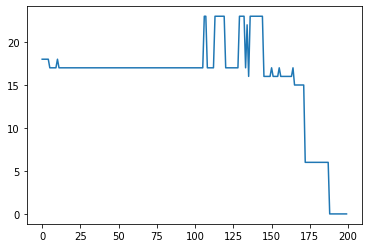

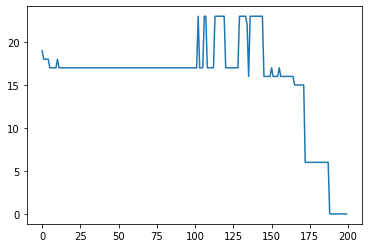

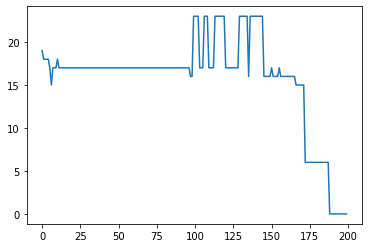

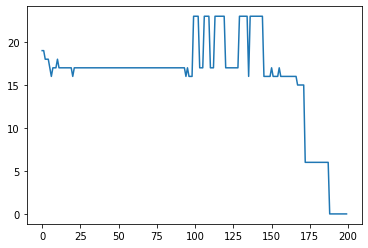

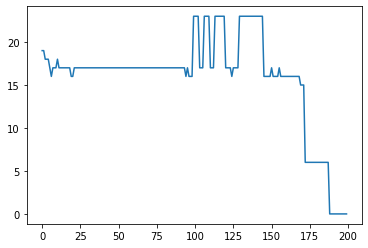

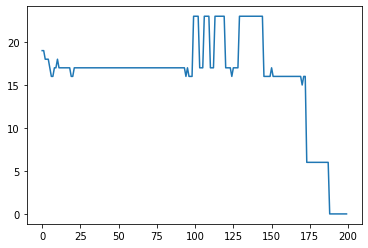

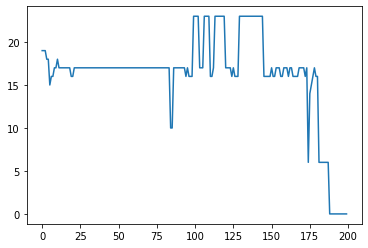

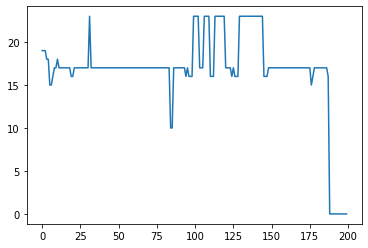

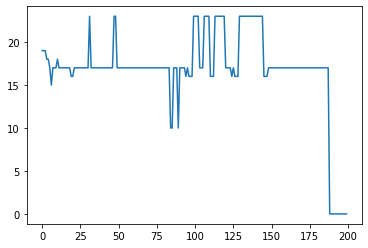

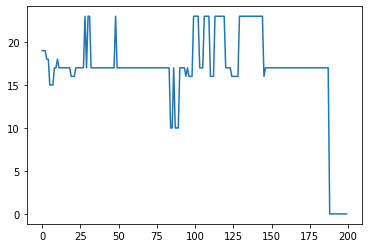

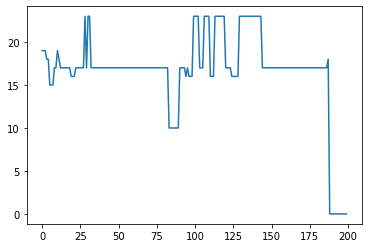

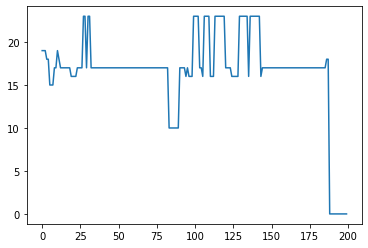

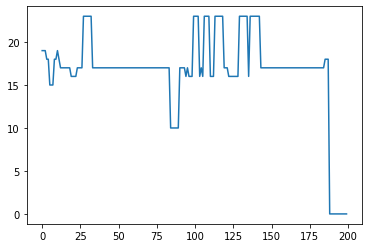

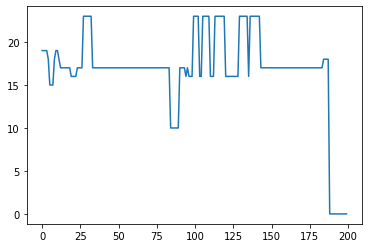

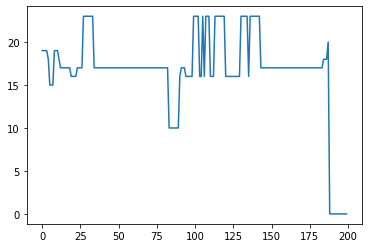

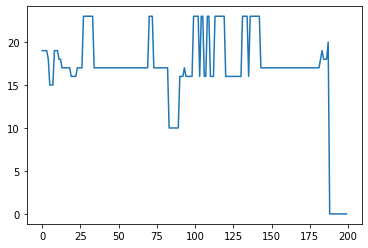

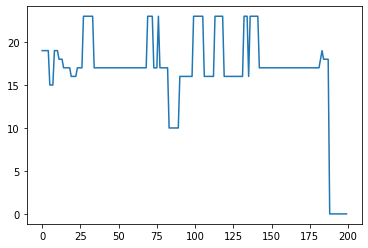

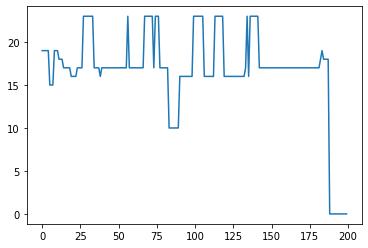

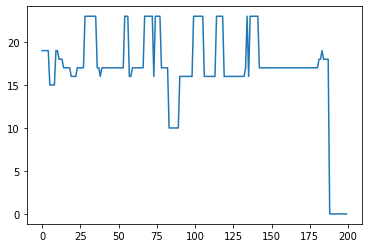

KeyboardInterrupt: ignored

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import time


for i in range(0, 200):
  y = disp_map[i, :]
  x = list(range(0, 200))
  plt.plot(x, y)
  plt.show()
  plt.pause(0.1)
  plt.close()